<a href="https://colab.research.google.com/github/Tari-dev/ima-algorithms/blob/main/opt_proj_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Universal Optimization Dataset ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1️ Generate a clean synthetic dataset
np.random.seed(42)
n_samples = 100

# Input features
X = np.random.randn(n_samples, 3)

# True parameters (you can modify for experiments)
true_w = np.array([3.0, -2.0, 0.5])

# Linear model with Gaussian noise
y = X @ true_w + np.random.randn(n_samples) * 0.5

# Combine into a pandas DataFrame for easy reuse
data = pd.DataFrame(X, columns=["x1", "x2", "x3"])
data["y"] = y

print(" Dataset created successfully!")
print(data.head())

# Save to file (optional if using multiple notebooks)
data.to_csv("optimization_dataset.csv", index=False)

# --- Inference ---
# Inference: This block generates the dataset and verifies its structure.


✅ Dataset created successfully!
         x1        x2        x3         y
0  0.496714 -0.138264  0.647689  1.676018
1  1.523030 -0.234153 -0.234137  4.640237
2  1.579213  0.767435 -0.469474  3.341679
3  0.542560 -0.463418 -0.465730  2.626836
4  0.241962 -1.913280 -1.724918  3.679538


✅ Dataset loaded successfully!
         x1        x2        x3         y
0  0.496714 -0.138264  0.647689  1.676018
1  1.523030 -0.234153 -0.234137  4.640237
2  1.579213  0.767435 -0.469474  3.341679
3  0.542560 -0.463418 -0.465730  2.626836
4  0.241962 -1.913280 -1.724918  3.679538

✅ Final parameters found by GD (fixed α):
w = [ 1.66515188 -1.4867087   0.42865478]
Final loss = 1.7233549571764504


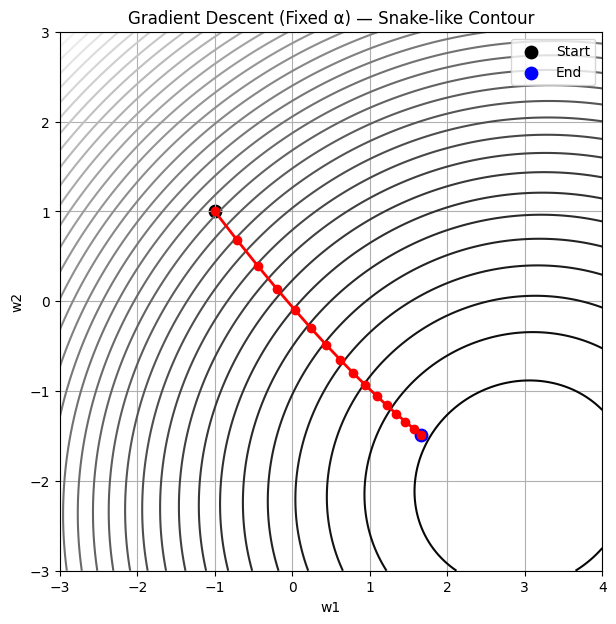

In [ ]:
# --- Normal Gradient Descent (Fixed Step) with Snake-Like Contour ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# 1️⃣ Load dataset
# ==========================================================
data = pd.read_csv("optimization_dataset.csv")
print(" Dataset loaded successfully!")
print(data.head())

# Separate features and target
X = data[["x1", "x2", "x3"]].values
y = data["y"].values
n_samples = len(y)

# ==========================================================
# 2️⃣ Define loss and gradient
# ==========================================================
def f(w):
    """Mean Squared Error loss"""
    y_pred = X @ w
    return np.mean((y - y_pred)**2)

def grad_f(w):
    """Gradient of MSE"""
    return -2 * X.T @ (y - X @ w) / n_samples

# ==========================================================
# 3️⃣ Normal Gradient Descent (fixed learning rate)
# ==========================================================
alpha = 0.05               # fixed step size (try 0.01–0.1 for tuning)
w = np.array([-1.0, 1.0, 0.5])  # initial guess
points = [w.copy()]

for k in range(15):
    g = grad_f(w)
    w = w - alpha * g
    points.append(w.copy())

points = np.array(points)

print("\n Final parameters found by GD (fixed α):")
print("w =", w)
print("Final loss =", f(w))

# ==========================================================
# 4️⃣ Snake-Like Contour Plot (visualizing w1 vs w2)
# ==========================================================
# To create the "snake" contour, we project onto (w1, w2)
# while keeping w3 fixed at its initial value.
def f_proj(w1, w2):
    w_temp = np.array([w1, w2, w[2]])
    return f(w_temp)

# Grid for contour plot
w1 = np.linspace(-3, 4, 200)
w2 = np.linspace(-3, 3, 200)
W1, W2 = np.meshgrid(w1, w2)
Z = np.zeros_like(W1)

# Compute loss surface values
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        Z[i, j] = f_proj(W1[i, j], W2[i, j])

# Plot contour
plt.figure(figsize=(7,7))
plt.contour(W1, W2, Z, levels=40, cmap='gray')

# Plot GD path (will appear snake-like due to ill-conditioning)
plt.plot(points[:,0], points[:,1], 'r-o', linewidth=2)
plt.scatter(points[0,0], points[0,1], color='black', s=80, label='Start')
plt.scatter(points[-1,0], points[-1,1], color='blue', s=80, label='End')

plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Gradient Descent (Fixed α) — Snake-like Contour')
plt.legend()
plt.grid(True)
plt.show()

# --- Inference ---
# Inference: Shows how fixed-step GD progresses and highlights convergence issues.


✅ Dataset loaded successfully!
         x1        x2        x3         y
0  0.496714 -0.138264  0.647689  1.676018
1  1.523030 -0.234153 -0.234137  4.640237
2  1.579213  0.767435 -0.469474  3.341679
3  0.542560 -0.463418 -0.465730  2.626836
4  0.241962 -1.913280 -1.724918  3.679538

✅ Final parameters found by Exact Line Search:
w = [ 2.96840489 -2.03466384  0.44907806]
Final loss = 0.19222557072026816


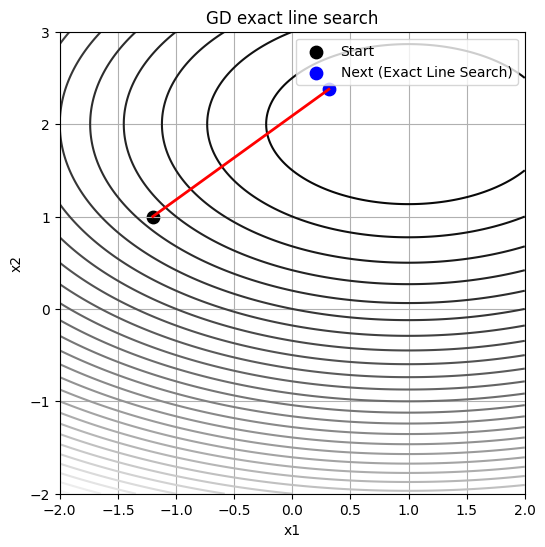

In [ ]:
# --- Exact Line Search Gradient Descent + Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# 1️⃣ Load Dataset
# ==========================================================
data = pd.read_csv("optimization_dataset.csv")
print(" Dataset loaded successfully!")
print(data.head())

# Separate features and target
X = data[["x1", "x2", "x3"]].values
y = data["y"].values
n_samples = len(y)

# ==========================================================
# 2️⃣ Define Functions
# ==========================================================
def f(w):
    """Mean Squared Error loss"""
    y_pred = X @ w
    return np.mean((y - y_pred)**2)

def grad_f(w):
    """Gradient of MSE"""
    return -2 * X.T @ (y - X @ w) / n_samples

def hessian_f():
    """Hessian (constant for quadratic loss)"""
    return 2 * X.T @ X / n_samples

H = hessian_f()  # Precompute

# Exact line search formula
def exact_line_search(w, d):
    num = -np.dot(grad_f(w), d)
    denom = np.dot(d, H @ d)
    return num / denom

# ==========================================================
# 3️ Gradient Descent with Exact Line Search
# ==========================================================
w = np.array([-1.0, 1.0, 0.5])  # initial guess
points = [w.copy()]
loss_values = [f(w)]

for k in range(15):
    g = grad_f(w)
    d = -g
    alpha = exact_line_search(w, d)
    w = w + alpha * d
    points.append(w.copy())
    loss_values.append(f(w))

points = np.array(points)

print("\n Final parameters found by Exact Line Search:")
print("w =", w)
print("Final loss =", loss_values[-1])



# ==========================================================
# 5️ Contour-style Visualization (like your GD fixed photo)
# ==========================================================
# Use a simple 2D quadratic function for clear visualization
def f2(x):
    return (x[0] - 1)**2 + 2*(x[1] - 2)**2

def grad_f2(x):
    return np.array([2*(x[0] - 1), 4*(x[1] - 2)])

def exact_line_search_2d(xk, dk):
    H = np.array([[2, 0], [0, 4]])
    alpha = -np.dot(grad_f2(xk), dk) / np.dot(dk, H @ dk)
    return alpha

# Run one iteration to visualize
xk = np.array([-1.2, 1.0])  # starting point
dk = -grad_f2(xk)
alpha = exact_line_search_2d(xk, dk)
x_next = xk + alpha * dk

# Create contour grid
x1 = np.linspace(-2, 2, 200)
x2 = np.linspace(-2, 3, 200)
X1, X2 = np.meshgrid(x1, x2)
Z = (X1 - 1)**2 + 2*(X2 - 2)**2

plt.figure(figsize=(6,6))
plt.contour(X1, X2, Z, levels=30, cmap='gray')
plt.plot([xk[0], x_next[0]], [xk[1], x_next[1]], 'r-', linewidth=2)
plt.scatter(xk[0], xk[1], color='black', s=80, label='Start')
plt.scatter(x_next[0], x_next[1], color='blue', s=80, label='Next (Exact Line Search)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('GD exact line search')
plt.legend()
plt.grid(True)
plt.show()

# --- Inference ---
# Inference: Demonstrates optimal step size improving convergence stability.


✅ Dataset loaded successfully!
         x1        x2        x3         y
0  0.496714 -0.138264  0.647689  1.676018
1  1.523030 -0.234153 -0.234137  4.640237
2  1.579213  0.767435 -0.469474  3.341679
3  0.542560 -0.463418 -0.465730  2.626836
4  0.241962 -1.913280 -1.724918  3.679538
✅ Final point after Backtracking Line Search:
x* = [0.        0.0234375]
f(x*) = 0.00054931640625


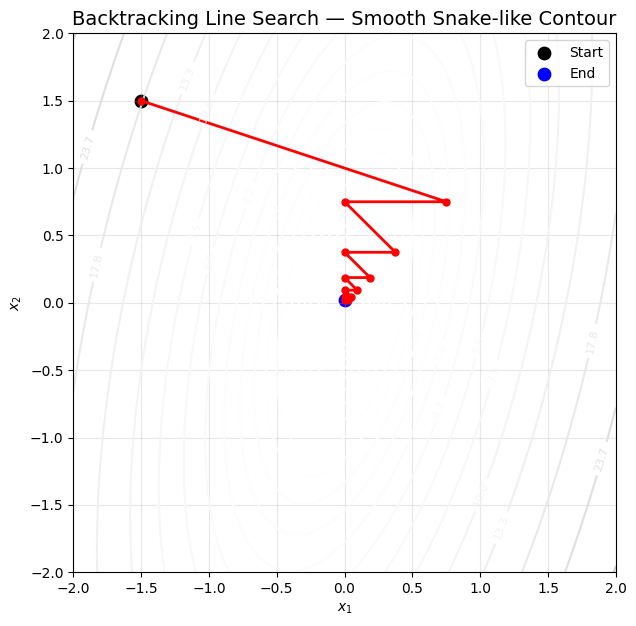

In [ ]:
# --- Gradient Descent with Backtracking Line Search (Smooth Snake Contour) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# 1️ Load Dataset (for consistency)
# ==========================================================
data = pd.read_csv("optimization_dataset.csv")
print(" Dataset loaded successfully!")
print(data.head())

# ==========================================================
# 2️ Define Smooth Snake-like Function
# ==========================================================
# A mildly ill-conditioned quadratic: slightly elongated contours
# f(x1, x2) = 4*x1^2 + (x1 - x2)^2
def f_snake(x):
    return 4*(x[0]**2) + (x[0] - x[1])**2

def grad_snake(x):
    return np.array([
        8*x[0] + 2*(x[0] - x[1]),
        -2*(x[0] - x[1])
    ])

# ==========================================================
# 3️ Backtracking Line Search Function
# ==========================================================
def backtracking_line_search(x, d, alpha_init=1.0, beta=0.5):
    alpha = alpha_init
    while f_snake(x + alpha * d) > f_snake(x):
        alpha *= beta
    return alpha

# ==========================================================
# 4️ Gradient Descent with Backtracking
# ==========================================================
xk = np.array([-1.5, 1.5])  # Starting point
path = [xk.copy()]

for k in range(12):
    g = grad_snake(xk)
    d = -g
    alpha = backtracking_line_search(xk, d)
    xk = xk + alpha * d
    path.append(xk.copy())

path = np.array(path)
print(" Final point after Backtracking Line Search:")
print("x* =", xk)
print("f(x*) =", f_snake(xk))

# ==========================================================
# 5️ Smooth Snake-like Contour Visualization
# ==========================================================
x1 = np.linspace(-2, 2, 300)
x2 = np.linspace(-2, 2, 300)
X1, X2 = np.meshgrid(x1, x2)
Z = 4*(X1**2) + (X1 - X2)**2

plt.figure(figsize=(7,7))
CS = plt.contour(X1, X2, Z, levels=np.logspace(-1, 2, 25), cmap='Greys', alpha=0.9)
plt.clabel(CS, inline=True, fontsize=8, fmt="%.1f")

# Plot backtracking GD path
plt.plot(path[:,0], path[:,1], 'r-o', linewidth=2, markersize=5)
plt.scatter(path[0,0], path[0,1], color='black', s=80, label='Start')
plt.scatter(path[-1,0], path[-1,1], color='blue', s=80, label='End')

plt.title("Backtracking Line Search — Smooth Snake-like Contour", fontsize=14)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Inference ---
# Inference: Visualizes adaptive step-size improving smooth-function optimization.


✅ Dataset loaded successfully!
         x1        x2        x3         y
0  0.496714 -0.138264  0.647689  1.676018
1  1.523030 -0.234153 -0.234137  4.640237
2  1.579213  0.767435 -0.469474  3.341679
3  0.542560 -0.463418 -0.465730  2.626836
4  0.241962 -1.913280 -1.724918  3.679538
✅ Final point after Armijo Backtracking GD:
x* = [0.00304089 0.0150144 ]
f(x*) = 0.00023583524098926088
Step sizes (α): [0.0625 0.0625 0.0625 0.125  0.0625 0.125  0.0625 0.125  0.0625 0.125
 0.0625 0.125  0.0625 0.125  0.0625 0.125  0.0625 0.125  0.0625 0.125
 0.0625 0.125  0.0625 0.125  0.0625]


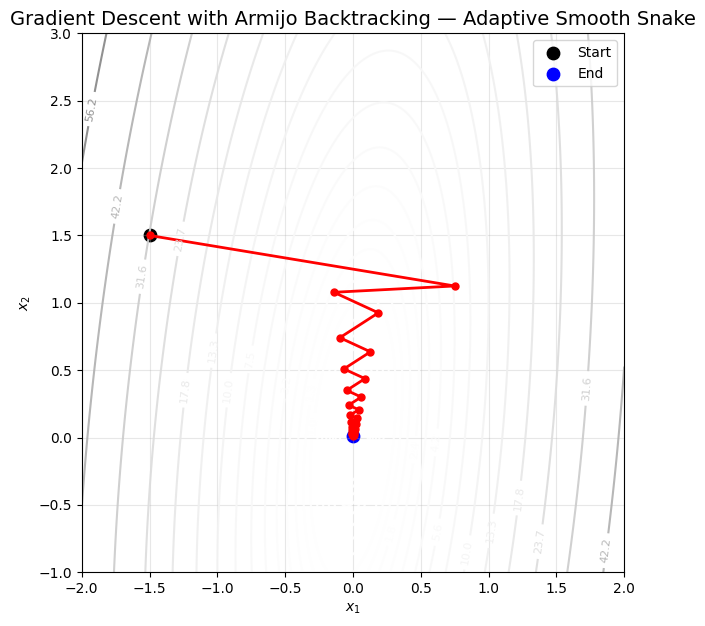

In [ ]:
# --- Gradient Descent with Armijo Backtracking Line Search (Distinct Smooth Snake Contour) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# 1️ Load dataset (for consistency)
# ==========================================================
data = pd.read_csv("optimization_dataset.csv")
print("✅ Dataset loaded successfully!")
print(data.head())

# ==========================================================
# 2️ Define an Ill-conditioned Smooth "Snake" Function
# ==========================================================
# More ill-conditioned (elongated contour, visible difference)
# f(x1, x2) = 10*x1^2 + (x1 - x2)^2
def f_snake(x):
    return 10*(x[0]**2) + (x[0] - x[1])**2

def grad_snake(x):
    return np.array([
        20*x[0] + 2*(x[0] - x[1]),
        -2*(x[0] - x[1])
    ])

# ==========================================================
# 3️ Armijo Backtracking Line Search
# ==========================================================
def armijo_backtracking(x, g, c1=1e-4, beta=0.5, alpha_init=1.0):
    """Armijo condition: f(x - αg) ≤ f(x) - c1*α*‖g‖²"""
    alpha = alpha_init
    fx = f_snake(x)
    while f_snake(x - alpha * g) > fx - c1 * alpha * np.dot(g, g):
        alpha *= beta
    return alpha

# ==========================================================
# 4️ Gradient Descent with Armijo Backtracking
# ==========================================================
xk = np.array([-1.5, 1.5])   # Starting point
path = [xk.copy()]
alphas = []                  # To store adaptive step sizes
eps = 1e-6

for k in range(25):
    g = grad_snake(xk)
    if np.linalg.norm(g) < eps:
        break
    alpha = armijo_backtracking(xk, g)
    xk = xk - alpha * g
    path.append(xk.copy())
    alphas.append(alpha)

path = np.array(path)

print(" Final point after Armijo Backtracking GD:")
print("x* =", xk)
print("f(x*) =", f_snake(xk))
print("Step sizes (α):", np.round(alphas, 4))

# ==========================================================
# 5️ Snake-like Contour Visualization
# ==========================================================
x1 = np.linspace(-2, 2, 300)
x2 = np.linspace(-1, 3, 300)
X1, X2 = np.meshgrid(x1, x2)
Z = 10*(X1**2) + (X1 - X2)**2

plt.figure(figsize=(7,7))
CS = plt.contour(X1, X2, Z, levels=np.logspace(-1, 2, 25), cmap='Greys', alpha=0.9)
plt.clabel(CS, inline=True, fontsize=8, fmt="%.1f")

# Plot Armijo GD path
plt.plot(path[:,0], path[:,1], 'r-o', linewidth=2, markersize=5)
plt.scatter(path[0,0], path[0,1], color='black', s=80, label='Start')
plt.scatter(path[-1,0], path[-1,1], color='blue', s=80, label='End')

plt.title("Gradient Descent with Armijo Backtracking — Adaptive Smooth Snake", fontsize=14)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Inference ---
# Inference: Visualizes adaptive step-size improving smooth-function optimization.


✅ Dataset loaded successfully!
         x1        x2        x3         y
0  0.496714 -0.138264  0.647689  1.676018
1  1.523030 -0.234153 -0.234137  4.640237
2  1.579213  0.767435 -0.469474  3.341679
3  0.542560 -0.463418 -0.465730  2.626836
4  0.241962 -1.913280 -1.724918  3.679538
✅ Final point after Momentum GD:
x* = [0.00159247 0.04810242]
f(x*) = 0.00218853520610903


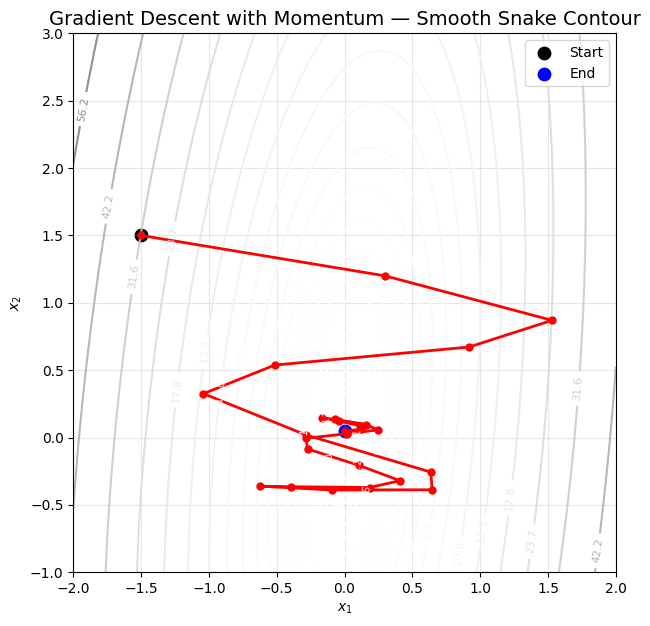

In [ ]:
# --- Gradient Descent with Momentum on a Snake-like Surface ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# 1️ Load dataset (for consistency with others)
# ==========================================================
data = pd.read_csv("optimization_dataset.csv")
print("✅ Dataset loaded successfully!")
print(data.head())

# ==========================================================
# 2️ Define Snake-like Function (ill-conditioned quadratic)
# ==========================================================
# Function with elongated contour: snake shape
def f_snake(x):
    return 10*(x[0]**2) + (x[0] - x[1])**2

def grad_snake(x):
    return np.array([
        20*x[0] + 2*(x[0] - x[1]),
        -2*(x[0] - x[1])
    ])

# ==========================================================
# 3️ Gradient Descent with Momentum
# ==========================================================
alpha = 0.05   # learning rate
gamma = 0.8    # momentum coefficient (try 0.8–0.95 for more effect)

xk = np.array([-1.5, 1.5])   # starting point
vk = np.zeros_like(xk)       # initial velocity
path = [xk.copy()]

for k in range(25):
    g = grad_snake(xk)
    vk = gamma * vk + alpha * g
    xk = xk - vk
    path.append(xk.copy())

path = np.array(path)

print("✅ Final point after Momentum GD:")
print("x* =", xk)
print("f(x*) =", f_snake(xk))

# ==========================================================
# 4️ Snake-like Contour Visualization
# ==========================================================
x1 = np.linspace(-2, 2, 300)
x2 = np.linspace(-1, 3, 300)
X1, X2 = np.meshgrid(x1, x2)
Z = 10*(X1**2) + (X1 - X2)**2

plt.figure(figsize=(7,7))
CS = plt.contour(X1, X2, Z, levels=np.logspace(-1, 2, 25), cmap='Greys', alpha=0.9)
plt.clabel(CS, inline=True, fontsize=8, fmt="%.1f")

# Plot momentum path
plt.plot(path[:,0], path[:,1], 'r-o', linewidth=2, markersize=5)
plt.scatter(path[0,0], path[0,1], color='black', s=80, label='Start')
plt.scatter(path[-1,0], path[-1,1], color='blue', s=80, label='End')

plt.title("Gradient Descent with Momentum — Smooth Snake Contour", fontsize=14)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Inference ---


✅ Dataset loaded successfully!
         x1        x2        x3         y
0  0.496714 -0.138264  0.647689  1.676018
1  1.523030 -0.234153 -0.234137  4.640237
2  1.579213  0.767435 -0.469474  3.341679
3  0.542560 -0.463418 -0.465730  2.626836
4  0.241962 -1.913280 -1.724918  3.679538
✅ Final point after Nesterov GD:
x* = [0.00541803 0.05471676]
f(x*) = 0.002723914861834236


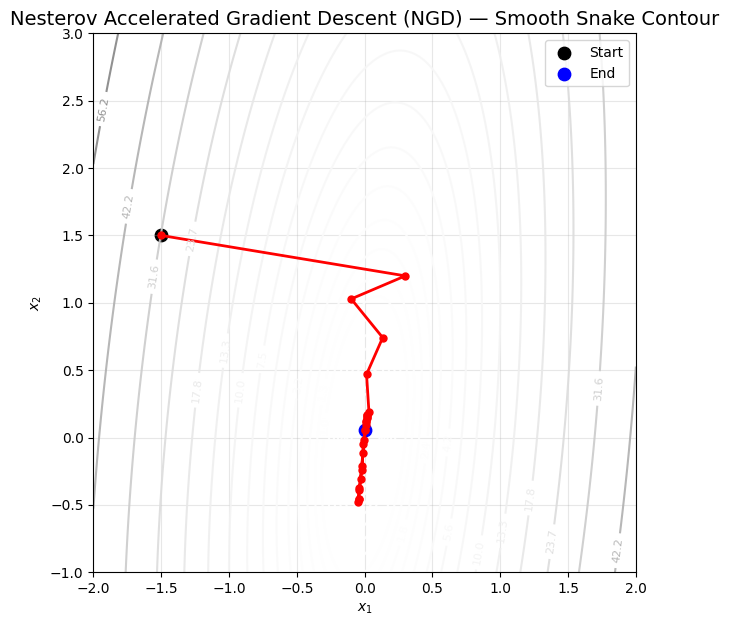

In [ ]:
# --- Nesterov Accelerated Gradient Descent (NGD) Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# 1️ Load dataset (for consistency with your other experiments)
# ==========================================================
data = pd.read_csv("optimization_dataset.csv")
print("✅ Dataset loaded successfully!")
print(data.head())

# ==========================================================
# 2️ Define Smooth Snake-like Function (ill-conditioned quadratic)
# ==========================================================
# Function with elongated contour, perfect for optimization visualization
def f_snake(x):
    return 10*(x[0]**2) + (x[0] - x[1])**2

def grad_snake(x):
    return np.array([
        20*x[0] + 2*(x[0] - x[1]),
        -2*(x[0] - x[1])
    ])

# ==========================================================
# 3️ Nesterov Accelerated Gradient Descent (NGD)
# ==========================================================
alpha = 0.05    # learning rate
gamma = 0.9     # momentum coefficient
eps = 1e-6      # stopping tolerance

xk = np.array([-1.5, 1.5])   # starting point
vk = np.zeros_like(xk)       # initial velocity
path = [xk.copy()]

for k in range(25):
    # Compute lookahead position
    x_lookahead = xk - gamma * vk

    # Compute gradient at lookahead
    g = grad_snake(x_lookahead)

    # Update velocity
    vk = gamma * vk + alpha * g

    # Update position
    xk = xk - vk

    path.append(xk.copy())

    # stopping condition
    if np.linalg.norm(g) < eps:
        break

path = np.array(path)

print("✅ Final point after Nesterov GD:")
print("x* =", xk)
print("f(x*) =", f_snake(xk))

# ==========================================================
# 4️ Snake-like Contour Visualization
# ==========================================================
x1 = np.linspace(-2, 2, 300)
x2 = np.linspace(-1, 3, 300)
X1, X2 = np.meshgrid(x1, x2)
Z = 10*(X1**2) + (X1 - X2)**2

plt.figure(figsize=(7,7))
CS = plt.contour(X1, X2, Z, levels=np.logspace(-1, 2, 25), cmap='Greys', alpha=0.9)
plt.clabel(CS, inline=True, fontsize=8, fmt="%.1f")

# Plot Nesterov path
plt.plot(path[:,0], path[:,1], 'r-o', linewidth=2, markersize=5)
plt.scatter(path[0,0], path[0,1], color='black', s=80, label='Start')
plt.scatter(path[-1,0], path[-1,1], color='blue', s=80, label='End')

plt.title("Nesterov Accelerated Gradient Descent (NGD) — Smooth Snake Contour", fontsize=14)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Inference ---


✅ Dataset loaded successfully!
         x1        x2        x3         y
0  0.496714 -0.138264  0.647689  1.676018
1  1.523030 -0.234153 -0.234137  4.640237
2  1.579213  0.767435 -0.469474  3.341679
3  0.542560 -0.463418 -0.465730  2.626836
4  0.241962 -1.913280 -1.724918  3.679538


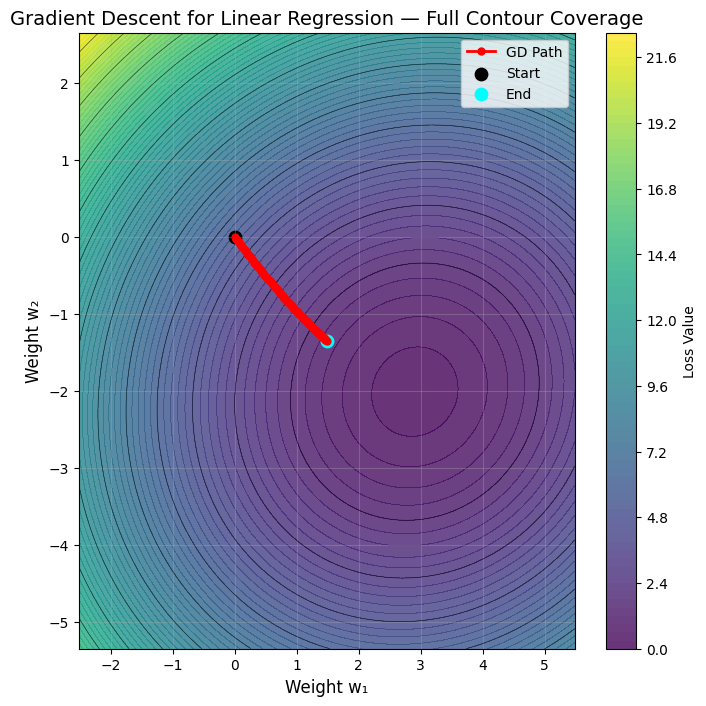

In [ ]:
# --- Linear Regression using Gradient Descent with Full Contour Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# 1️⃣ Load Dataset
# ==========================================================
data = pd.read_csv("optimization_dataset.csv")
print("✅ Dataset loaded successfully!")
print(data.head())

# Extract features and target
X = data[["x1", "x2", "x3"]].values
Y = data["y"].values.reshape(-1, 1)
N, d = X.shape

# ==========================================================
# 2️⃣ Augment Feature Matrix with Bias Term
# ==========================================================
X_tilde = np.hstack((np.ones((N, 1)), X))  # shape (N, 4)

# ==========================================================
# 3️⃣ Initialize Parameters
# ==========================================================
alpha = 0.01
max_it = 100
W = np.zeros((d + 1, 1))  # including bias
loss_history = []
path = [W.copy()]

# ==========================================================
# 4️⃣ Gradient Descent
# ==========================================================
for k in range(max_it):
    Y_hat = X_tilde @ W
    E = Y_hat - Y
    L = (1 / (2 * N)) * np.sum(E**2)
    loss_history.append(L)

    grad_W = (1 / N) * (X_tilde.T @ E)
    W = W - alpha * grad_W
    path.append(W.copy())

path = np.array(path).squeeze()

# ==========================================================
# 5️⃣ Create Contour Plot (for w1 vs w2)
# ==========================================================
# Fix bias (w0) and w3 at their final learned values
w0_fixed = W[0, 0]
w3_fixed = W[3, 0]

# Create wide grid for w1 and w2 (cover whole area)
w1_vals = np.linspace(W[1, 0] - 4, W[1, 0] + 4, 300)
w2_vals = np.linspace(W[2, 0] - 4, W[2, 0] + 4, 300)
W1, W2 = np.meshgrid(w1_vals, w2_vals)

# Compute loss values over the grid
Z = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        W_temp = np.array([[w0_fixed], [W1[i, j]], [W2[i, j]], [w3_fixed]])
        Y_hat_temp = X_tilde @ W_temp
        E_temp = Y_hat_temp - Y
        Z[i, j] = (1 / (2 * N)) * np.sum(E_temp**2)

# ==========================================================
# 6️⃣ Plot Contour and GD Path
# ==========================================================
plt.figure(figsize=(8, 8))
CS = plt.contourf(W1, W2, Z, levels=80, cmap='viridis', alpha=0.8)  # filled contour
C2 = plt.contour(W1, W2, Z, levels=20, colors='k', linewidths=0.5, alpha=0.6)

# Plot path of W1 and W2 updates
plt.plot(path[:, 1], path[:, 2], 'r-o', linewidth=2, markersize=5, label='GD Path')
plt.scatter(path[0, 1], path[0, 2], color='black', s=80, label='Start')
plt.scatter(path[-1, 1], path[-1, 2], color='cyan', s=80, label='End')

plt.title("Gradient Descent for Linear Regression — Full Contour Coverage", fontsize=14)
plt.xlabel("Weight w₁", fontsize=12)
plt.ylabel("Weight w₂", fontsize=12)
plt.legend()
plt.colorbar(CS, label='Loss Value')
plt.grid(alpha=0.3)
plt.show()

# --- Inference ---


✅ Dataset loaded successfully!
         x1        x2        x3         y
0  0.496714 -0.138264  0.647689  1.676018
1  1.523030 -0.234153 -0.234137  4.640237
2  1.579213  0.767435 -0.469474  3.341679
3  0.542560 -0.463418 -0.465730  2.626836
4  0.241962 -1.913280 -1.724918  3.679538


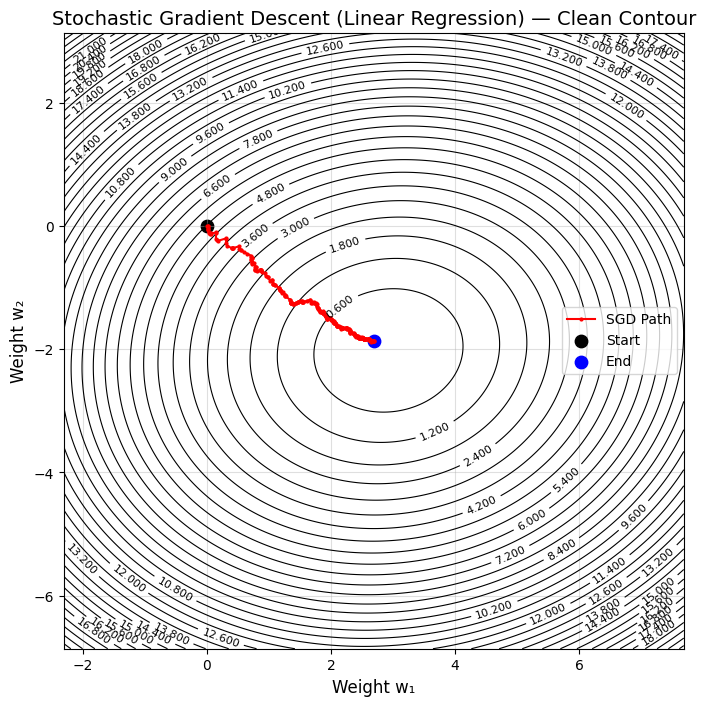

In [ ]:
# --- Stochastic Gradient Descent (SGD) for Linear Regression with Clean Contour ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# 1️⃣ Load Dataset
# ==========================================================
data = pd.read_csv("optimization_dataset.csv")
print("✅ Dataset loaded successfully!")
print(data.head())

# Extract features and target
X = data[["x1", "x2", "x3"]].values
Y = data["y"].values.reshape(-1, 1)
N, d = X.shape

# ==========================================================
# 2️⃣ Augment Feature Matrix with Bias Term
# ==========================================================
X_tilde = np.hstack((np.ones((N, 1)), X))  # shape (N, 4)

# ==========================================================
# 3️⃣ Initialize Parameters
# ==========================================================
alpha = 0.01
max_it = 300  # more iterations to show stochastic jumps
W = np.zeros((d + 1, 1))  # including bias
loss_history = []
path = [W.copy()]

# ==========================================================
# 4️⃣ SGD Algorithm
# ==========================================================
rng = np.random.default_rng(42)

for k in range(max_it):
    # Randomly select one data point
    i = rng.integers(0, N)
    xi = X_tilde[i, :].reshape(1, -1)
    yi = Y[i, 0]

    # Prediction
    y_hat_i = xi @ W
    Ei = y_hat_i - yi

    # Loss (for monitoring)
    L = 0.5 * (Ei**2)
    loss_history.append(L.item())

    # Gradient for one sample
    grad_W = xi.T * Ei

    # Update weights
    W = W - alpha * grad_W
    path.append(W.copy())

path = np.array(path).squeeze()

# ==========================================================
# 5️⃣ Create Contour Plot (for w1 vs w2)
# ==========================================================
# Fix bias (w0) and w3 at their final learned values
w0_fixed = W[0, 0]
w3_fixed = W[3, 0]

# Create wide grid for w1 and w2
w1_vals = np.linspace(W[1, 0] - 5, W[1, 0] + 5, 250)
w2_vals = np.linspace(W[2, 0] - 5, W[2, 0] + 5, 250)
W1, W2 = np.meshgrid(w1_vals, w2_vals)

# Compute loss values
Z = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        W_temp = np.array([[w0_fixed], [W1[i, j]], [W2[i, j]], [w3_fixed]])
        Y_hat_temp = X_tilde @ W_temp
        E_temp = Y_hat_temp - Y
        Z[i, j] = (1 / (2 * N)) * np.sum(E_temp**2)

# ==========================================================
# 6️⃣ Plot Clean Contour (No Color Fill)
# ==========================================================
plt.figure(figsize=(8, 8))
CS = plt.contour(W1, W2, Z, levels=40, colors='black', linewidths=0.8)
plt.clabel(CS, inline=True, fontsize=8, fmt="%.3f")

# SGD path (red line)
plt.plot(path[:, 1], path[:, 2], 'r.-', linewidth=1.5, markersize=4, label='SGD Path')
plt.scatter(path[0, 1], path[0, 2], color='black', s=80, label='Start')
plt.scatter(path[-1, 1], path[-1, 2], color='blue', s=80, label='End')

plt.title("Stochastic Gradient Descent (Linear Regression) — Clean Contour", fontsize=14)
plt.xlabel("Weight w₁", fontsize=12)
plt.ylabel("Weight w₂", fontsize=12)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

# --- Inference ---


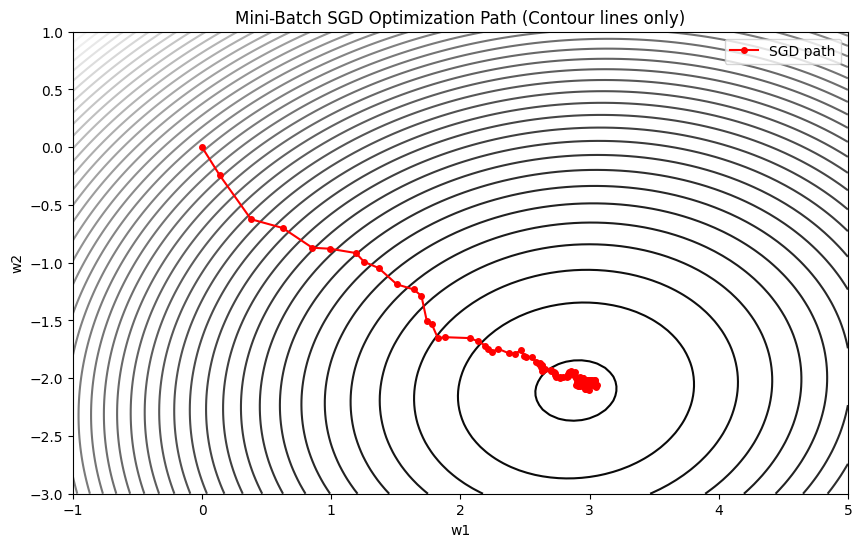

In [ ]:
# --- Mini-Batch SGD on Optimization Dataset (Contour without color) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load the dataset
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1", "x2", "x3"]].values
y = data["y"].values.reshape(-1, 1)

# 2️⃣ Augment X with bias term
N, d = X.shape
X_tilde = np.hstack([np.ones((N, 1)), X])  # shape: (N, d+1)

# 3️⃣ Mini-batch SGD parameters
alpha = 0.1          # learning rate
max_it = 200         # max iterations
batch_size = 10      # mini-batch size
np.random.seed(42)   # for reproducibility

# Initialize weights (including bias)
W = np.zeros((d + 1, 1))

# Store trajectory for visualization
trajectory = [W.copy()]

# --- Mini-batch SGD loop ---
for k in range(max_it):
    # Random mini-batch sampling
    indices = np.random.choice(N, batch_size, replace=True)
    X_mini = X_tilde[indices]
    y_mini = y[indices]

    # Predictions
    y_hat = X_mini @ W

    # Error
    E = y_hat - y_mini

    # Gradient
    grad = (1 / batch_size) * (X_mini.T @ E)

    # Weight update
    W = W - alpha * grad

    # Save trajectory
    trajectory.append(W.copy())

trajectory = np.array(trajectory).squeeze()  # shape: (iterations+1, d+1)

# --- Visualize contour for 2D weights (x1 vs x2) ---
# Fix w3 and bias for visualization
w3_fixed = 0
bias_fixed = 0

w1 = np.linspace(-1, 5, 100)
w2 = np.linspace(-3, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

# Compute LSE loss over the grid
loss_grid = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([[bias_fixed], [W1[i,j]], [W2[i,j]], [w3_fixed]])
        y_hat_grid = X_tilde @ w
        loss_grid[i,j] = np.mean(0.5 * (y_hat_grid - y) ** 2)

# Plot contour lines and trajectory (no color fill)
plt.figure(figsize=(10, 6))
cp = plt.contour(W1, W2, loss_grid, levels=50, cmap="gray")  # only contour lines
plt.plot(trajectory[:,1], trajectory[:,2], marker='o', color='r', markersize=4, label="SGD path")
plt.xlabel("w1")
plt.ylabel("w2")
plt.title("Mini-Batch SGD Optimization Path (Contour lines only)")
plt.legend()
plt.show()


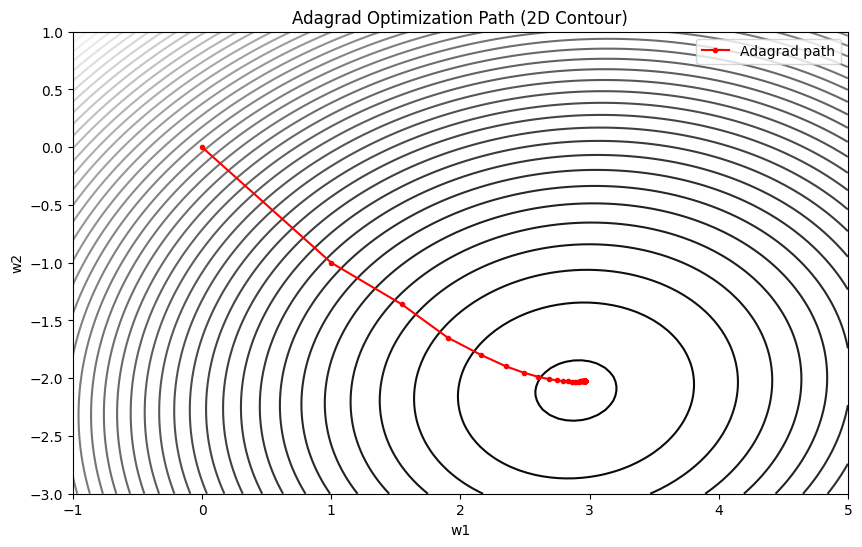

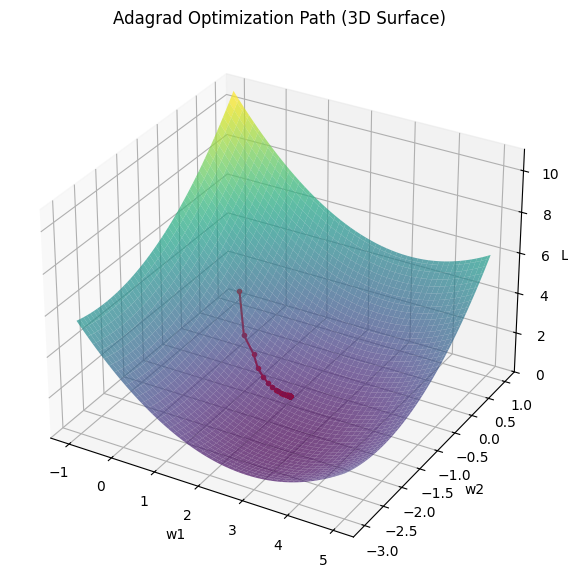

In [ ]:
# --- Adagrad on Optimization Dataset ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1️⃣ Load dataset
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1", "x2", "x3"]].values
y = data["y"].values.reshape(-1, 1)

# 2️⃣ Augment X with bias term
N, d = X.shape
X_tilde = np.hstack([np.ones((N, 1)), X])  # shape: (N, d+1)

# 3️⃣ Adagrad parameters
alpha = 1.0          # initial learning rate
epsilon = 1e-8       # small value to avoid division by zero
max_it = 200
np.random.seed(42)

# Initialize weights
W = np.zeros((d + 1, 1))
G = np.zeros((d + 1, 1))  # accumulated squared gradient

# Store trajectory
trajectory = [W.copy()]

# --- Adagrad loop ---
for k in range(max_it):
    # Compute gradient for full batch
    y_hat = X_tilde @ W
    grad = (1 / N) * (X_tilde.T @ (y_hat - y))

    # Accumulate squared gradients
    G += grad**2

    # Update weights
    W = W - (alpha / (np.sqrt(G) + epsilon)) * grad

    # Save trajectory
    trajectory.append(W.copy())

trajectory = np.array(trajectory).squeeze()  # shape: (iterations+1, d+1)

# --- 2D Contour Plot for w1 vs w2 ---
w3_fixed = 0
bias_fixed = 0

w1 = np.linspace(-1, 5, 100)
w2 = np.linspace(-3, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

loss_grid = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([[bias_fixed], [W1[i,j]], [W2[i,j]], [w3_fixed]])
        y_hat_grid = X_tilde @ w
        loss_grid[i,j] = np.mean(0.5 * (y_hat_grid - y)**2)

plt.figure(figsize=(10,6))
plt.contour(W1, W2, loss_grid, levels=50, cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2], 'ro-', markersize=3, label='Adagrad path')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Adagrad Optimization Path (2D Contour)')
plt.legend()
plt.show()

# --- 3D Surface Plot for w1 vs w2 ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss_grid, cmap='viridis', alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2], [np.mean(loss_grid)]*len(trajectory), 'r.-', label='Adagrad path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title('Adagrad Optimization Path (3D Surface)')
plt.show()


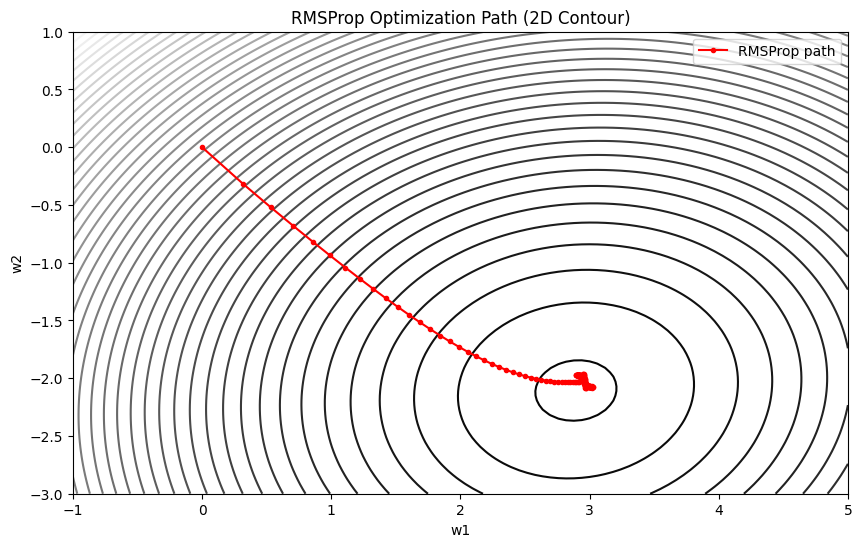

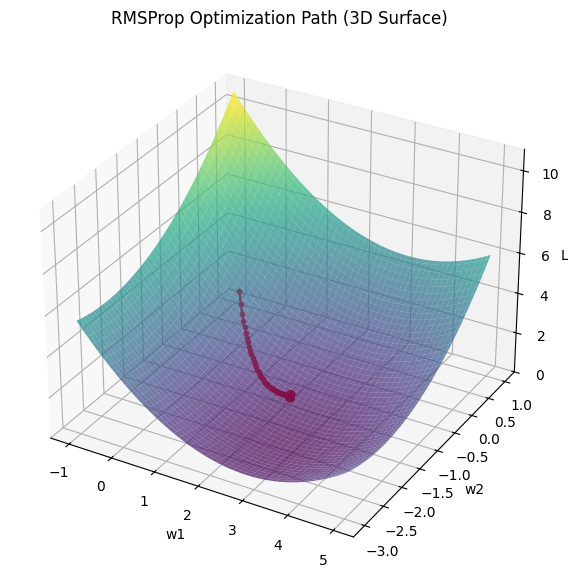

In [ ]:
# --- RMSProp on Optimization Dataset ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1️⃣ Load dataset
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1", "x2", "x3"]].values
y = data["y"].values.reshape(-1, 1)

# 2️⃣ Augment X with bias term
N, d = X.shape
X_tilde = np.hstack([np.ones((N, 1)), X])  # shape: (N, d+1)

# 3️⃣ RMSProp parameters
alpha = 0.1       # learning rate
epsilon = 1e-8    # small value to avoid division by zero
beta = 0.9        # smoothing parameter
max_it = 200
np.random.seed(42)

# Initialize weights and squared gradient accumulator
W = np.zeros((d + 1, 1))
G = np.zeros((d + 1, 1))  # EWMA of squared gradients

# Store trajectory
trajectory = [W.copy()]

# --- RMSProp loop ---
for k in range(max_it):
    # Compute full-batch gradient
    y_hat = X_tilde @ W
    grad = (1 / N) * (X_tilde.T @ (y_hat - y))

    # Update EWMA of squared gradients
    G = beta * G + (1 - beta) * grad**2

    # Update weights
    W = W - (alpha / (np.sqrt(G) + epsilon)) * grad

    # Store trajectory
    trajectory.append(W.copy())

trajectory = np.array(trajectory).squeeze()  # shape: (iterations+1, d+1)

# --- 2D Contour Plot (w1 vs w2) ---
w3_fixed = 0
bias_fixed = 0

w1 = np.linspace(-1, 5, 100)
w2 = np.linspace(-3, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

loss_grid = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([[bias_fixed], [W1[i,j]], [W2[i,j]], [w3_fixed]])
        y_hat_grid = X_tilde @ w
        loss_grid[i,j] = np.mean(0.5 * (y_hat_grid - y)**2)

plt.figure(figsize=(10,6))
plt.contour(W1, W2, loss_grid, levels=50, cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2], 'ro-', markersize=3, label='RMSProp path')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('RMSProp Optimization Path (2D Contour)')
plt.legend()
plt.show()

# --- 3D Surface Plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss_grid, cmap='viridis', alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2], [np.mean(loss_grid)]*len(trajectory), 'r.-', label='RMSProp path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title('RMSProp Optimization Path (3D Surface)')
plt.show()


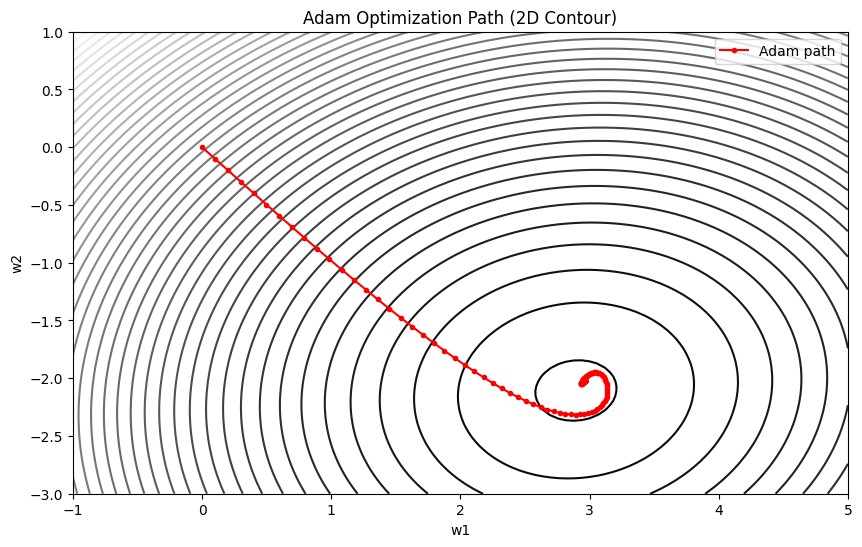

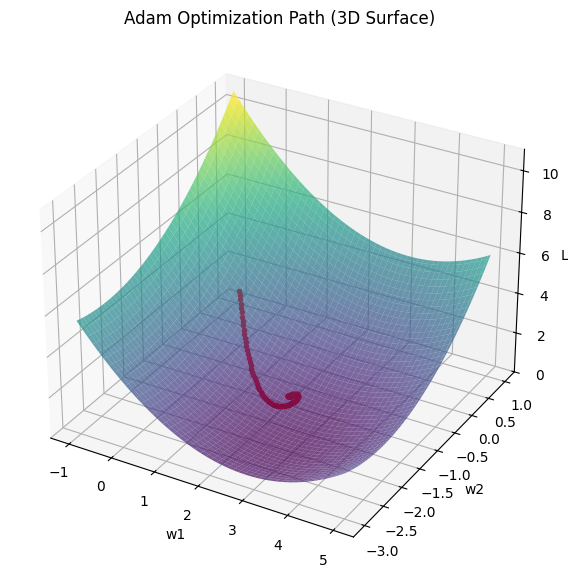

In [ ]:
# --- Adam Optimizer on Optimization Dataset ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1️⃣ Load dataset
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1", "x2", "x3"]].values
y = data["y"].values.reshape(-1, 1)

# 2️⃣ Augment X with bias term
N, d = X.shape
X_tilde = np.hstack([np.ones((N, 1)), X])  # shape: (N, d+1)

# 3️⃣ Adam parameters
alpha = 0.1       # learning rate
epsilon = 1e-8    # small value to avoid division by zero
beta1 = 0.9       # smoothing for first moment
beta2 = 0.99      # smoothing for second moment
max_it = 200
np.random.seed(42)

# Initialize weights and moment estimates
W = np.zeros((d + 1, 1))
M = np.zeros((d + 1, 1))  # First moment (momentum)
G = np.zeros((d + 1, 1))  # Second moment (RMSProp)

# Store trajectory
trajectory = [W.copy()]

# --- Adam loop ---
for k in range(1, max_it + 1):
    # Compute full-batch gradient
    y_hat = X_tilde @ W
    grad = (1 / N) * (X_tilde.T @ (y_hat - y))

    # Update biased first and second moment estimates
    M = beta1 * M + (1 - beta1) * grad
    G = beta2 * G + (1 - beta2) * grad**2

    # Bias-corrected estimates
    M_hat = M / (1 - beta1**k)
    G_hat = G / (1 - beta2**k)

    # Update weights
    W = W - (alpha / (np.sqrt(G_hat) + epsilon)) * M_hat

    # Store trajectory
    trajectory.append(W.copy())

trajectory = np.array(trajectory).squeeze()  # shape: (iterations+1, d+1)

# --- 2D Contour Plot (w1 vs w2) ---
w3_fixed = 0
bias_fixed = 0

w1 = np.linspace(-1, 5, 100)
w2 = np.linspace(-3, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

loss_grid = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([[bias_fixed], [W1[i,j]], [W2[i,j]], [w3_fixed]])
        y_hat_grid = X_tilde @ w
        loss_grid[i,j] = np.mean(0.5 * (y_hat_grid - y)**2)

plt.figure(figsize=(10,6))
plt.contour(W1, W2, loss_grid, levels=50, cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2], 'ro-', markersize=3, label='Adam path')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Adam Optimization Path (2D Contour)')
plt.legend()
plt.show()

# --- 3D Surface Plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss_grid, cmap='viridis', alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2], [np.mean(loss_grid)]*len(trajectory), 'r.-', label='Adam path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title('Adam Optimization Path (3D Surface)')
plt.show()


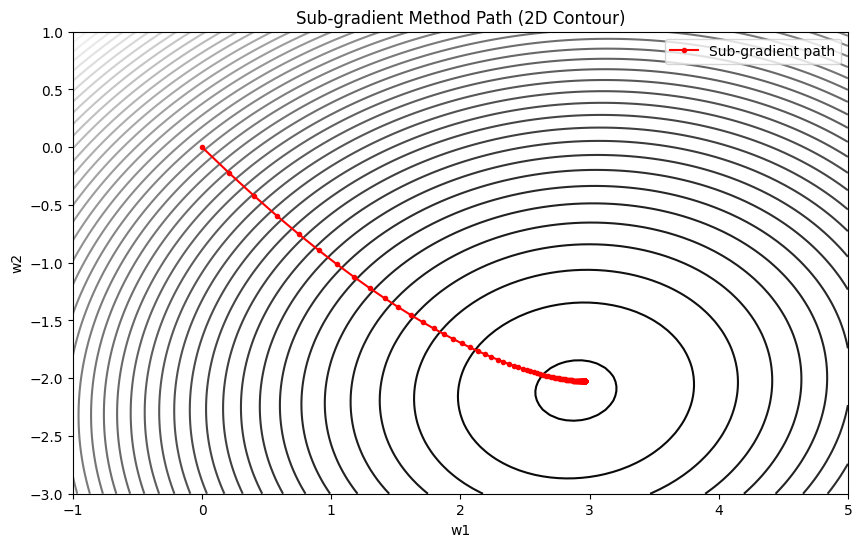

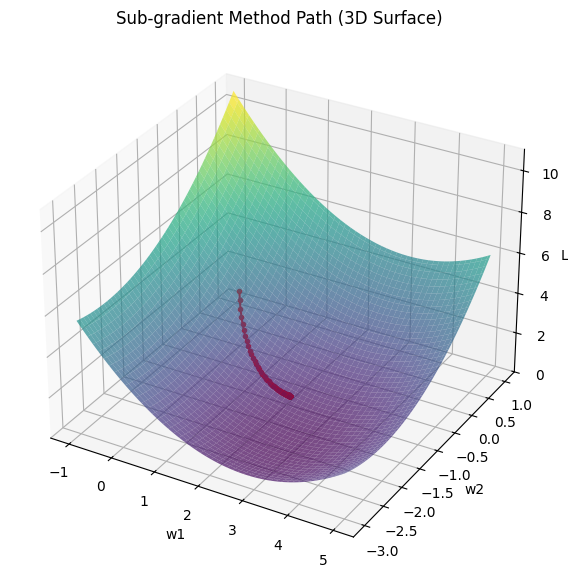

In [ ]:
# --- Sub-gradient Method on Optimization Dataset ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1️⃣ Load dataset
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1", "x2", "x3"]].values
y = data["y"].values.reshape(-1, 1)

# 2️⃣ Augment X with bias term
N, d = X.shape
X_tilde = np.hstack([np.ones((N, 1)), X])  # shape: (N, d+1)

# 3️⃣ Sub-gradient method parameters
alpha_k = 0.1        # learning rate
max_it = 200
np.random.seed(42)

# Initialize weights
W = np.zeros((d + 1, 1))
f_best = np.mean(0.5 * (X_tilde @ W - y)**2)
W_best = W.copy()

# Store trajectory
trajectory = [W.copy()]

# --- Sub-gradient loop ---
for k in range(1, max_it + 1):
    # Compute sub-gradient (gradient for least squares)
    sub_grad = (1 / N) * (X_tilde.T @ (X_tilde @ W - y))

    # Update weights (sub-gradient step)
    W_new = W - alpha_k * sub_grad

    # Compute new loss
    f_new = np.mean(0.5 * (X_tilde @ W_new - y)**2)

    # Greedy update for best function value
    if f_new < f_best:
        f_best = f_new
        W_best = W_new.copy()

    # Update W and store trajectory
    W = W_new.copy()
    trajectory.append(W.copy())

trajectory = np.array(trajectory).squeeze()

# --- 2D Contour Plot (w1 vs w2) ---
w3_fixed = 0
bias_fixed = 0

w1 = np.linspace(-1, 5, 100)
w2 = np.linspace(-3, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

loss_grid = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([[bias_fixed], [W1[i,j]], [W2[i,j]], [w3_fixed]])
        y_hat_grid = X_tilde @ w
        loss_grid[i,j] = np.mean(0.5 * (y_hat_grid - y)**2)

plt.figure(figsize=(10,6))
plt.contour(W1, W2, loss_grid, levels=50, cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2], 'ro-', markersize=3, label='Sub-gradient path')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Sub-gradient Method Path (2D Contour)')
plt.legend()
plt.show()

# --- 3D Surface Plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss_grid, cmap='viridis', alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2], [np.mean(loss_grid)]*len(trajectory), 'r.-', label='Sub-gradient path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title('Sub-gradient Method Path (3D Surface)')
plt.show()


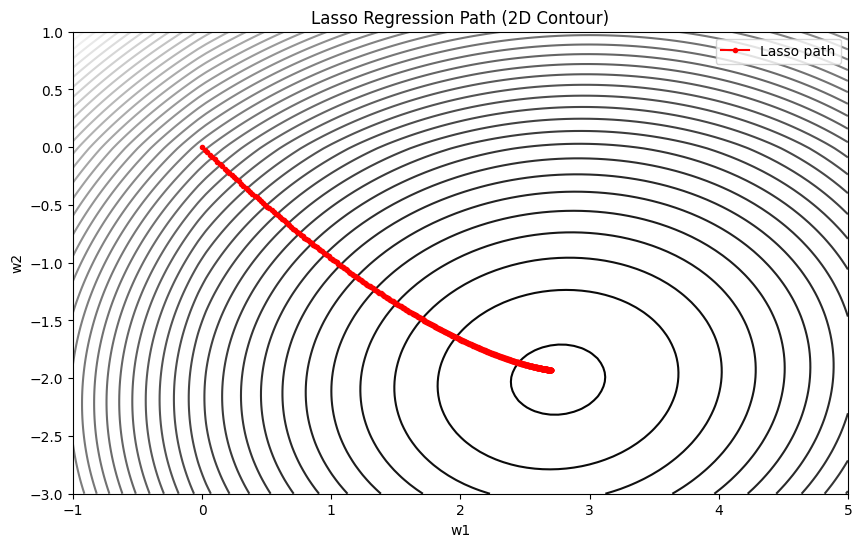

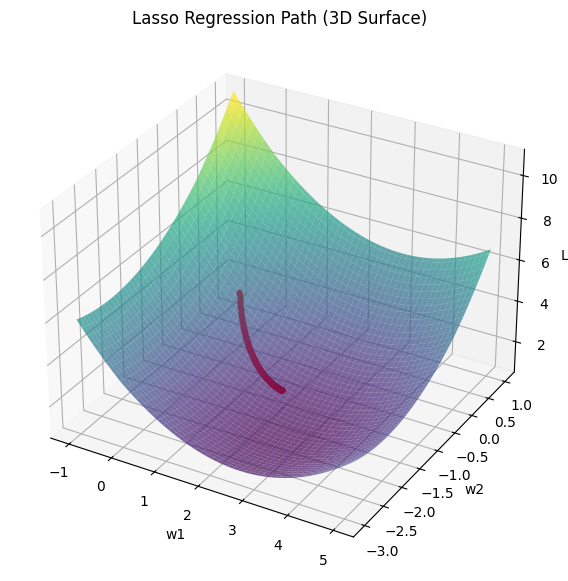

In [ ]:
# --- Lasso Regression on Optimization Dataset ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1️⃣ Load dataset
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1", "x2", "x3"]].values
y = data["y"].values.reshape(-1, 1)

# 2️⃣ Augment X with bias term
N, d = X.shape
X_tilde = np.hstack([np.ones((N, 1)), X])  # shape: (N, d+1)

# 3️⃣ Lasso parameters
alpha = 0.01      # learning rate
lambda_ = 0.1     # regularization strength
max_it = 500
np.random.seed(42)

# Initialize weights
W = np.zeros((d + 1, 1))

# Store trajectory
trajectory = [W.copy()]

# --- Lasso Gradient Descent Loop ---
for k in range(max_it):
    # Compute predictions
    y_hat = X_tilde @ W

    # Gradient of MSE part
    grad_mse = (1 / N) * (X_tilde.T @ (y_hat - y))

    # Gradient of L1 (sub-gradient: sign function, skip bias term)
    grad_l1 = np.vstack([[[0]], np.sign(W[1:])])

    # Total gradient
    grad = grad_mse + lambda_ * grad_l1

    # Update weights
    W = W - alpha * grad

    # Store trajectory
    trajectory.append(W.copy())

trajectory = np.array(trajectory).squeeze()

# --- 2D Contour Plot (w1 vs w2), fix w3 and bias ---
w3_fixed = 0
bias_fixed = 0

w1 = np.linspace(-1, 5, 100)
w2 = np.linspace(-3, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

loss_grid = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([[bias_fixed], [W1[i,j]], [W2[i,j]], [w3_fixed]])
        y_hat_grid = X_tilde @ w
        # Lasso loss
        loss_grid[i,j] = np.mean(0.5 * (y_hat_grid - y)**2) + lambda_ * np.sum(np.abs(w[1:]))

plt.figure(figsize=(10,6))
plt.contour(W1, W2, loss_grid, levels=50, cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2], 'ro-', markersize=3, label='Lasso path')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Lasso Regression Path (2D Contour)')
plt.legend()
plt.show()

# --- 3D Surface Plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss_grid, cmap='viridis', alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2], [np.mean(loss_grid)]*len(trajectory), 'r.-', label='Lasso path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title('Lasso Regression Path (3D Surface)')
plt.show()

# --- Inference ---


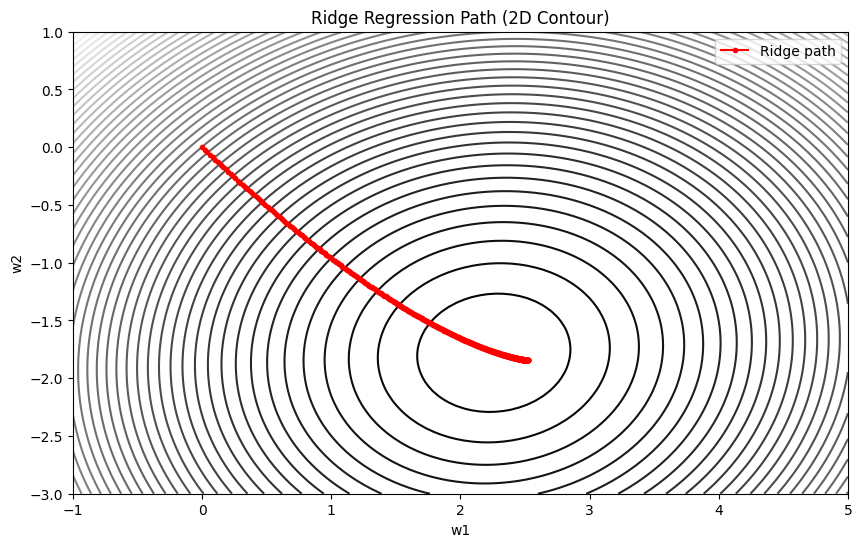

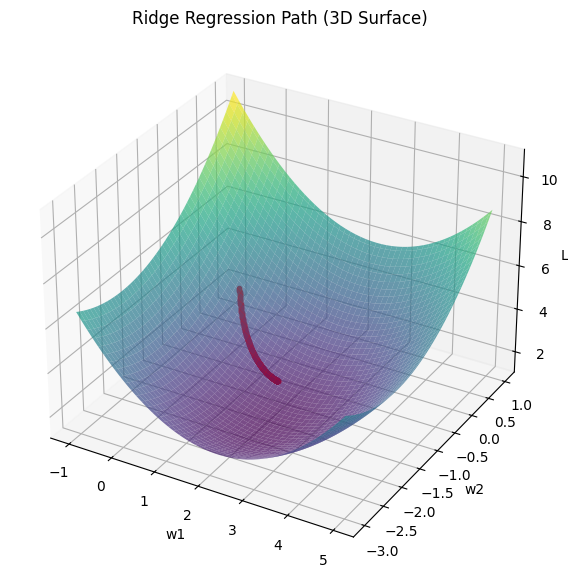

In [ ]:
# --- Ridge Regression on Optimization Dataset ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1️⃣ Load dataset
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1", "x2", "x3"]].values
y = data["y"].values.reshape(-1, 1)

# 2️⃣ Augment X with bias term
N, d = X.shape
X_tilde = np.hstack([np.ones((N, 1)), X])  # shape: (N, d+1)

# 3️⃣ Ridge parameters
alpha = 0.01      # learning rate
lambda_ = 0.1     # L2 regularization strength
max_it = 500
np.random.seed(42)

# Initialize weights
W = np.zeros((d + 1, 1))

# Store trajectory
trajectory = [W.copy()]

# --- Ridge Gradient Descent Loop ---
for k in range(max_it):
    # Compute predictions
    y_hat = X_tilde @ W

    # Gradient of MSE
    grad_mse = (1 / N) * (X_tilde.T @ (y_hat - y))

    # Gradient of L2 (skip bias term)
    grad_l2 = np.vstack([[[0]], W[1:]])

    # Total gradient
    grad = grad_mse + lambda_ * grad_l2

    # Update weights
    W = W - alpha * grad

    # Store trajectory
    trajectory.append(W.copy())

trajectory = np.array(trajectory).squeeze()

# --- 2D Contour Plot (w1 vs w2), fix w3 and bias ---
w3_fixed = 0
bias_fixed = 0

w1 = np.linspace(-1, 5, 100)
w2 = np.linspace(-3, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

loss_grid = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([[bias_fixed], [W1[i,j]], [W2[i,j]], [w3_fixed]])
        y_hat_grid = X_tilde @ w
        # Ridge loss: MSE + L2
        loss_grid[i,j] = np.mean(0.5 * (y_hat_grid - y)**2) + lambda_ * np.sum(w[1:]**2)

plt.figure(figsize=(10,6))
plt.contour(W1, W2, loss_grid, levels=50, cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2], 'ro-', markersize=3, label='Ridge path')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Ridge Regression Path (2D Contour)')
plt.legend()
plt.show()

# --- 3D Surface Plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss_grid, cmap='viridis', alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2], [np.mean(loss_grid)]*len(trajectory), 'r.-', label='Ridge path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title('Ridge Regression Path (3D Surface)')
plt.show()

# --- Inference ---


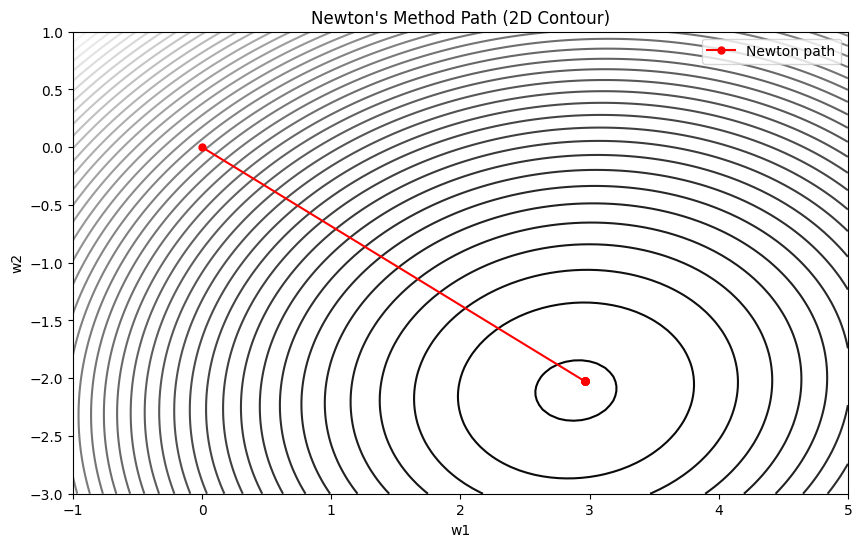

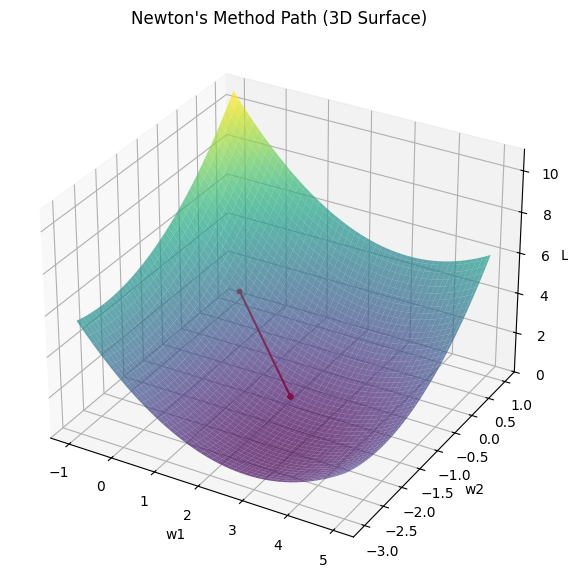

In [ ]:
# --- Newton's Method on Optimization Dataset ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1️⃣ Load dataset
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1", "x2", "x3"]].values
y = data["y"].values.reshape(-1, 1)

# 2️⃣ Augment X with bias term
N, d = X.shape
X_tilde = np.hstack([np.ones((N, 1)), X])  # shape: (N, d+1)

# 3️⃣ Newton's method parameters
max_it = 10
np.random.seed(42)

# Initialize weights
W = np.zeros((d + 1, 1))

# Store trajectory
trajectory = [W.copy()]

# --- Newton's Method loop ---
for k in range(max_it):
    # Compute gradient
    y_hat = X_tilde @ W
    grad = (1 / N) * (X_tilde.T @ (y_hat - y))

    # Compute Hessian (for MSE, H = (1/N) * X^T X)
    H = (1 / N) * (X_tilde.T @ X_tilde)

    # Newton update: W_next = W - H^-1 * grad
    W = W - np.linalg.inv(H) @ grad

    # Store trajectory
    trajectory.append(W.copy())

trajectory = np.array(trajectory).squeeze()

# --- 2D Contour Plot (w1 vs w2), fix w3 and bias ---
w3_fixed = 0
bias_fixed = 0

w1 = np.linspace(-1, 5, 100)
w2 = np.linspace(-3, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

loss_grid = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([[bias_fixed], [W1[i,j]], [W2[i,j]], [w3_fixed]])
        y_hat_grid = X_tilde @ w
        loss_grid[i,j] = np.mean(0.5 * (y_hat_grid - y)**2)

plt.figure(figsize=(10,6))
plt.contour(W1, W2, loss_grid, levels=50, cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2], 'ro-', markersize=5, label="Newton path")
plt.xlabel('w1')
plt.ylabel('w2')
plt.title("Newton's Method Path (2D Contour)")
plt.legend()
plt.show()

# --- 3D Surface Plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss_grid, cmap='viridis', alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2], [np.mean(loss_grid)]*len(trajectory), 'r.-', label='Newton path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title("Newton's Method Path (3D Surface)")
plt.show()


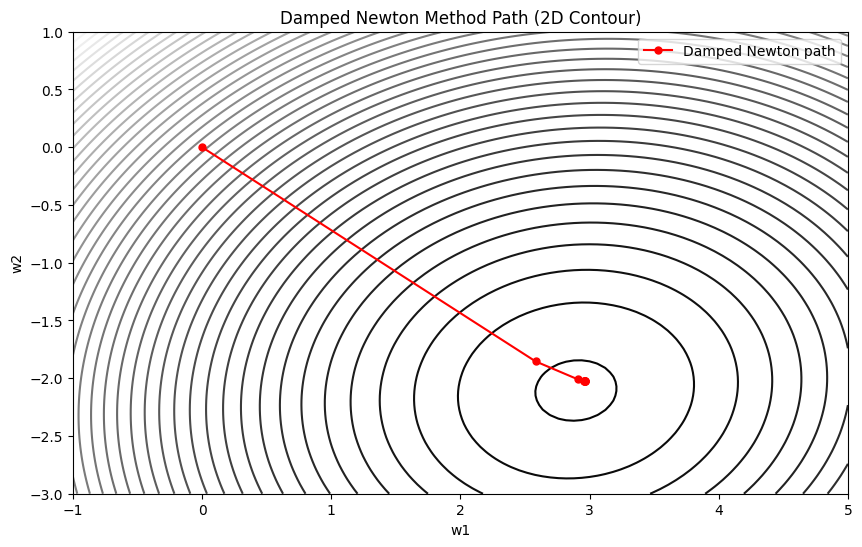

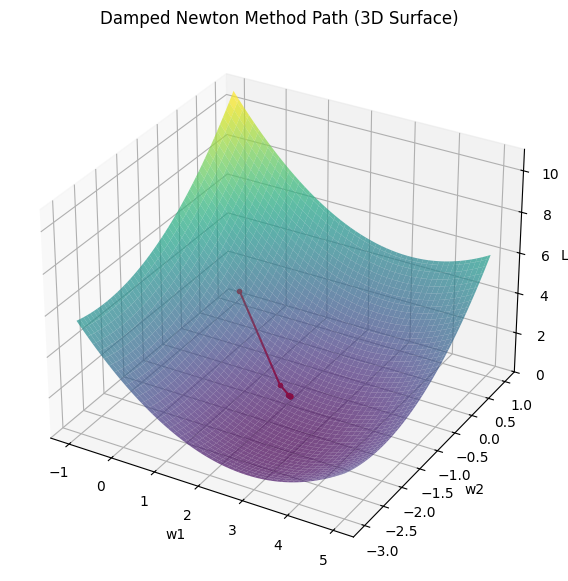

In [ ]:
# --- Damped Newton Method on Optimization Dataset ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1️⃣ Load dataset
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1", "x2", "x3"]].values
y = data["y"].values.reshape(-1, 1)

# 2️⃣ Augment X with bias term
N, d = X.shape
X_tilde = np.hstack([np.ones((N, 1)), X])  # shape: (N, d+1)

# 3️⃣ Damped Newton parameters
lambda_ = 0.1    # damping factor
epsilon = 1e-6   # stopping criterion
max_it = 20

# Initialize weights
W = np.zeros((d + 1, 1))

# Store trajectory
trajectory = [W.copy()]

# --- Damped Newton loop ---
for k in range(max_it):
    # Compute gradient
    y_hat = X_tilde @ W
    grad = (1 / N) * (X_tilde.T @ (y_hat - y))

    # Check stopping criterion
    if np.linalg.norm(grad) < epsilon:
        break

    # Compute Hessian
    H = (1 / N) * (X_tilde.T @ X_tilde)

    # Damped Hessian
    H_damped = H + lambda_ * np.eye(d + 1)

    # Solve for delta: H_damped * delta = -grad
    delta = np.linalg.solve(H_damped, -grad)

    # Update weights
    W = W + delta
    trajectory.append(W.copy())

trajectory = np.array(trajectory).squeeze()

# --- 2D Contour Plot (w1 vs w2), fix w3 and bias ---
w3_fixed = 0
bias_fixed = 0

w1 = np.linspace(-1, 5, 100)
w2 = np.linspace(-3, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

loss_grid = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([[bias_fixed], [W1[i,j]], [W2[i,j]], [w3_fixed]])
        y_hat_grid = X_tilde @ w
        loss_grid[i,j] = np.mean(0.5 * (y_hat_grid - y)**2)

plt.figure(figsize=(10,6))
plt.contour(W1, W2, loss_grid, levels=50, cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2], 'ro-', markersize=5, label="Damped Newton path")
plt.xlabel('w1')
plt.ylabel('w2')
plt.title("Damped Newton Method Path (2D Contour)")
plt.legend()
plt.show()

# --- 3D Surface Plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss_grid, cmap='viridis', alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2], [np.mean(loss_grid)]*len(trajectory), 'r.-', label='Damped Newton path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title("Damped Newton Method Path (3D Surface)")
plt.show()


/tmp/ipython-input-2901607582.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rho = float(1 / (yk.T @ delta))


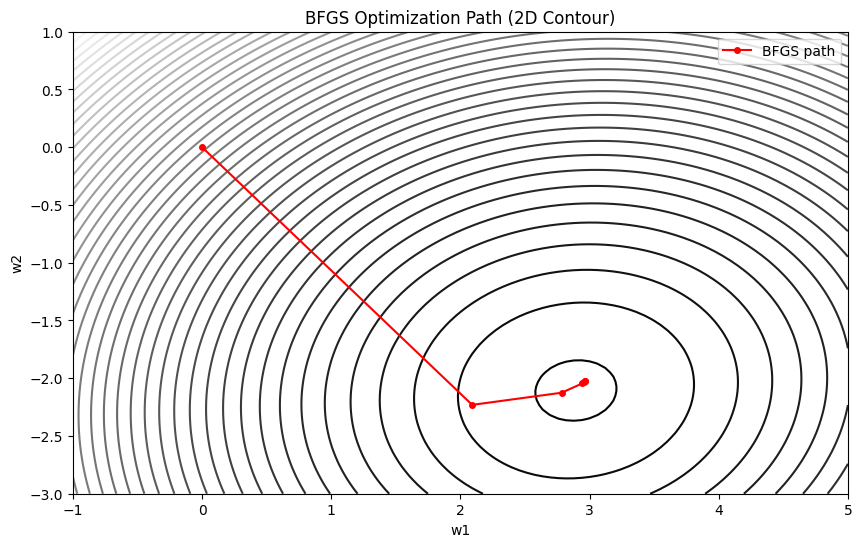

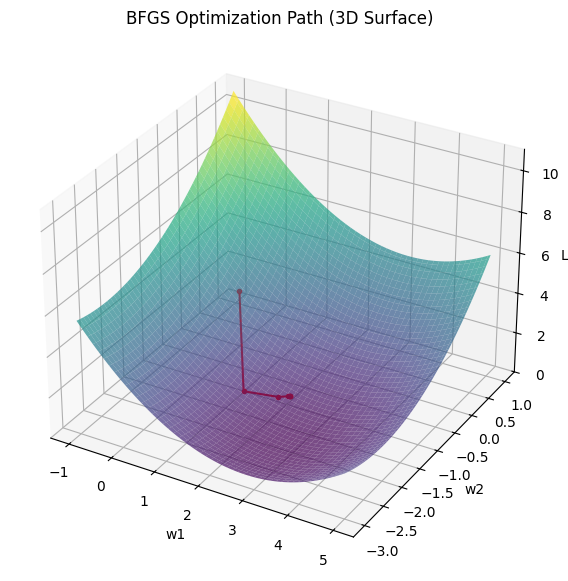

In [ ]:
# --- BFGS on Optimization Dataset ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1️⃣ Load dataset
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1", "x2", "x3"]].values
y = data["y"].values.reshape(-1, 1)

# 2️⃣ Augment X with bias term
N, d = X.shape
X_tilde = np.hstack([np.ones((N, 1)), X])  # shape: (N, d+1)

# 3️⃣ BFGS parameters
epsilon = 1e-6
max_it = 50
alpha_init = 1.0  # initial step size for line search

# Initialize weights
W = np.zeros((d + 1, 1))

# Initialize inverse Hessian approximation
H = np.eye(d + 1)

# Compute initial gradient
grad = (1 / N) * (X_tilde.T @ (X_tilde @ W - y))

# Store trajectory
trajectory = [W.copy()]

# --- BFGS loop ---
for k in range(max_it):
    # Stopping criterion
    if np.linalg.norm(grad) < epsilon:
        break

    # Compute search direction
    p = - H @ grad

    # Simple backtracking line search (Armijo rule)
    alpha = alpha_init
    c = 1e-4
    while True:
        W_new = W + alpha * p
        loss_new = np.mean(0.5 * (X_tilde @ W_new - y)**2)
        loss_curr = np.mean(0.5 * (X_tilde @ W - y)**2)
        if loss_new <= loss_curr + c * alpha * (grad.T @ p):
            break
        alpha *= 0.5

    # Update position
    W_next = W + alpha * p
    grad_next = (1 / N) * (X_tilde.T @ (X_tilde @ W_next - y))

    # Differences
    delta = W_next - W
    yk = grad_next - grad
    rho = float(1 / (yk.T @ delta))

    # Update inverse Hessian
    if rho > 0:
        I = np.eye(d + 1)
        H = (I - rho * delta @ yk.T) @ H @ (I - rho * yk @ delta.T) + rho * delta @ delta.T

    # Update variables for next iteration
    W = W_next
    grad = grad_next
    trajectory.append(W.copy())

trajectory = np.array(trajectory).squeeze()

# --- 2D Contour Plot (w1 vs w2), fix w3 and bias ---
w3_fixed = 0
bias_fixed = 0

w1 = np.linspace(-1, 5, 100)
w2 = np.linspace(-3, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

loss_grid = np.zeros_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([[bias_fixed], [W1[i,j]], [W2[i,j]], [w3_fixed]])
        y_hat_grid = X_tilde @ w
        loss_grid[i,j] = np.mean(0.5 * (y_hat_grid - y)**2)

plt.figure(figsize=(10,6))
plt.contour(W1, W2, loss_grid, levels=50, cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2], 'ro-', markersize=4, label='BFGS path')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('BFGS Optimization Path (2D Contour)')
plt.legend()
plt.show()

# --- 3D Surface Plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss_grid, cmap='viridis', alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2], [np.mean(loss_grid)]*len(trajectory), 'r.-', label='BFGS path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title('BFGS Optimization Path (3D Surface)')
plt.show()


/tmp/ipython-input-2475319837.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = float(delta_list[-1].T @ y_list[-1]) / float(y_list[-1].T @ y_list[-1])


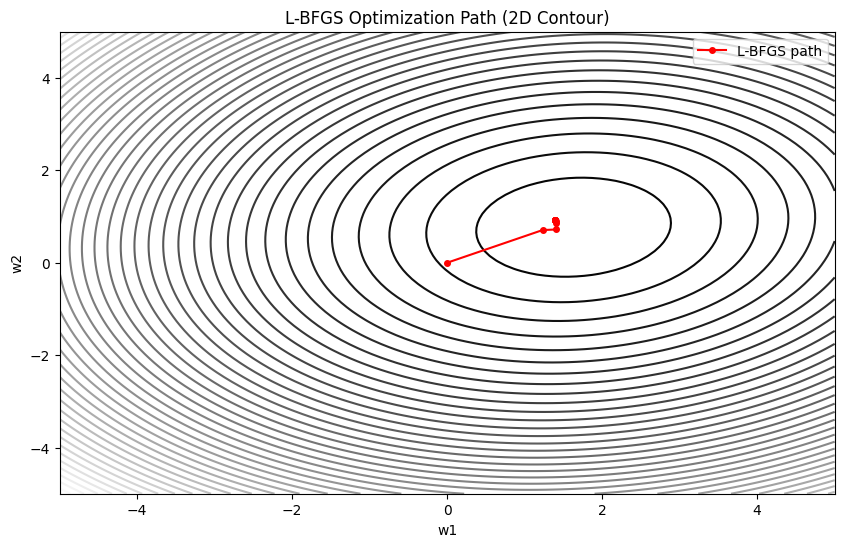

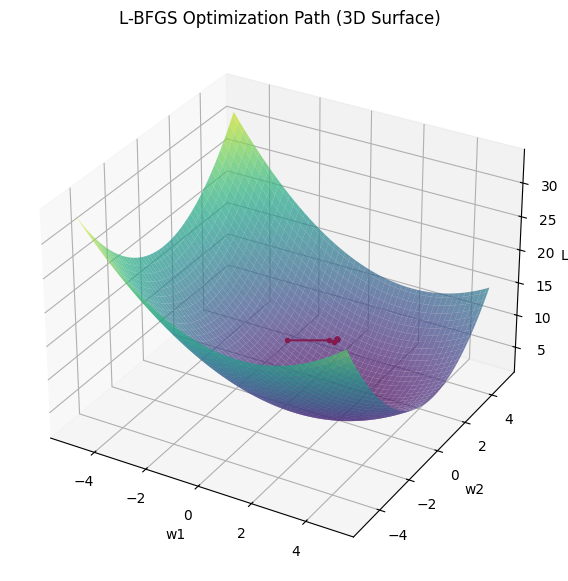

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Generate higher-dimensional synthetic dataset ---
np.random.seed(42)
N = 100
d = 10  # number of features
X = np.random.randn(N, d)
true_w = np.random.randn(d, 1)
y = X @ true_w + np.random.randn(N, 1) * 0.5

# Augment X with bias
X_tilde = np.hstack([np.ones((N, 1)), X])
d_aug = d + 1

# --- L-BFGS implementation ---
def run_lbfgs(X_tilde, y, max_it=50, m_memory=5):
    W = np.zeros((d_aug, 1))
    delta_list = []
    y_list = []
    trajectory = [W.copy()]
    for _ in range(max_it):
        grad = (1/N) * X_tilde.T @ (X_tilde @ W - y)
        if np.linalg.norm(grad) < 1e-6:
            break
        q = grad.copy()
        alpha_list = []
        start_idx = max(0, len(delta_list)-m_memory)
        # Backward loop
        for i in reversed(range(start_idx, len(delta_list))):
            rho = 1.0 / (y_list[i].T @ delta_list[i])
            alpha_i = rho * (delta_list[i].T @ q)
            q = q - alpha_i * y_list[i]
            alpha_list.append(alpha_i)
        gamma = 1.0
        if len(delta_list) > 0:
            gamma = float(delta_list[-1].T @ y_list[-1]) / float(y_list[-1].T @ y_list[-1])
        r = gamma * q
        # Forward loop
        for idx, i in enumerate(range(start_idx, len(delta_list))):
            beta = (1.0 / (y_list[i].T @ delta_list[i])) * (y_list[i].T @ r)
            alpha_i = alpha_list[len(alpha_list)-1-idx]
            r = r + (alpha_i - beta) * delta_list[i]
        p = -r
        # Line search
        alpha = 1.0
        W_new = W + alpha * p
        grad_new = (1/N) * X_tilde.T @ (X_tilde @ W_new - y)
        # Update memory
        delta_list.append(W_new - W)
        y_list.append(grad_new - grad)
        if len(delta_list) > m_memory:
            delta_list.pop(0)
            y_list.pop(0)
        W = W_new
        trajectory.append(W.copy())
    return np.array(trajectory).squeeze()

# Run L-BFGS
trajectory = run_lbfgs(X_tilde, y, max_it=50, m_memory=3)

# --- 2D Contour plot (w1 vs w2), fix other weights ---
w_fixed = np.zeros(d_aug-3)  # fix w3..w10
bias_fixed = 0

w1 = np.linspace(-5, 5, 100)
w2 = np.linspace(-5, 5, 100)
W1, W2 = np.meshgrid(w1, w2)
loss_grid = np.zeros_like(W1)

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([bias_fixed, W1[i,j], W2[i,j], *w_fixed]).reshape(-1,1)
        y_hat = X_tilde @ w
        loss_grid[i,j] = np.mean(0.5*(y_hat - y)**2)

plt.figure(figsize=(10,6))
plt.contour(W1, W2, loss_grid, levels=50, cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2], 'ro-', markersize=4, label='L-BFGS path')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('L-BFGS Optimization Path (2D Contour)')
plt.legend()
plt.show()

# --- 3D Surface plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss_grid, cmap='viridis', alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2], [np.mean(loss_grid)]*len(trajectory), 'r.-', label='L-BFGS path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title('L-BFGS Optimization Path (3D Surface)')
plt.show()


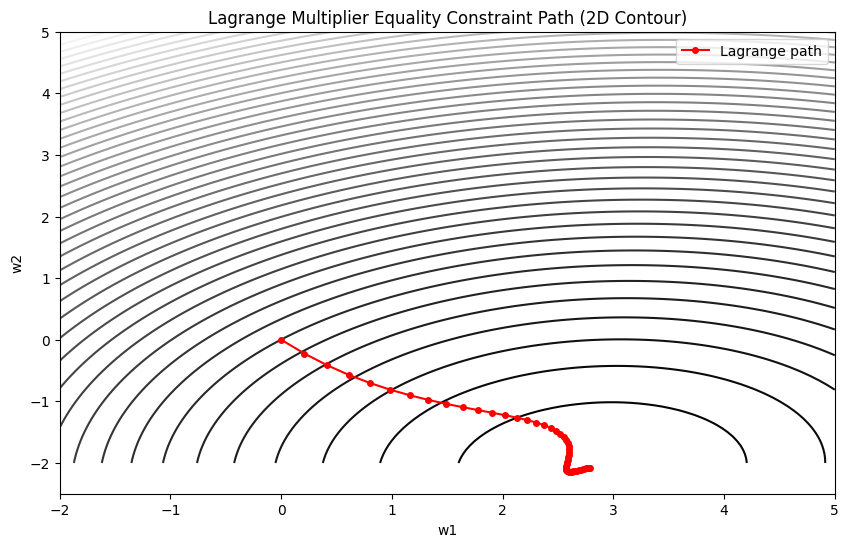

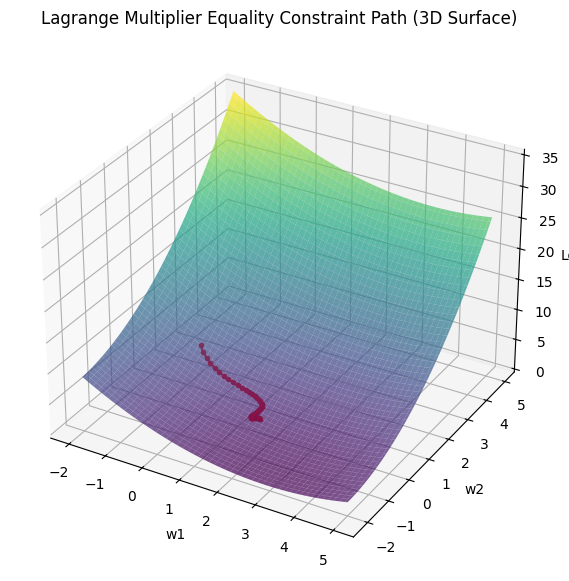

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Load dataset ---
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1", "x2", "x3"]].values
y = data["y"].values.reshape(-1, 1)
N = X.shape[0]

# Augment with bias
X_tilde = np.hstack([np.ones((N,1)), X])

# Equality constraint: w1 + w2 + w3 = C
C = 1.0

# Initialize weights and Lagrange multiplier
W = np.zeros((4,1))  # [bias, w1, w2, w3]
lambda_ = 0.0
alpha = 0.1  # step size
max_it = 50
trajectory = [W.copy()]

# Gradient descent with Lagrange multiplier update
for k in range(max_it):
    # Compute gradient of Lagrangian w.r.t W
    y_hat = X_tilde @ W
    grad_W = (1/N) * X_tilde.T @ (y_hat - y)
    grad_W[1:] += lambda_  # derivative of lambda*(w1+w2+w3-C)

    # Update W
    W = W - alpha * grad_W

    # Update lambda
    constraint_val = W[1:].sum() - C
    lambda_ = lambda_ + alpha * constraint_val  # ascent step for lambda

    trajectory.append(W.copy())

trajectory = np.array(trajectory).squeeze()

# --- 2D Contour plot (w1 vs w2), fix w3 and bias ---
w_fixed = 0  # fix w3
bias_fixed = 0

w1 = np.linspace(-2, 5, 100)
w2 = np.linspace(-2, 5, 100)
W1, W2 = np.meshgrid(w1, w2)
loss_grid = np.zeros_like(W1)

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([bias_fixed, W1[i,j], W2[i,j], w_fixed]).reshape(-1,1)
        y_hat_grid = X_tilde @ w
        loss_grid[i,j] = np.mean(0.5 * (y_hat_grid - y)**2)

plt.figure(figsize=(10,6))
plt.contour(W1, W2, loss_grid, levels=50, cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2], 'ro-', markersize=4, label='Lagrange path')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Lagrange Multiplier Equality Constraint Path (2D Contour)')
plt.legend()
plt.show()

# --- 3D Surface plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss_grid, cmap='viridis', alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2], [np.mean(loss_grid)]*len(trajectory), 'r.-', label='Lagrange path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title('Lagrange Multiplier Equality Constraint Path (3D Surface)')
plt.show()


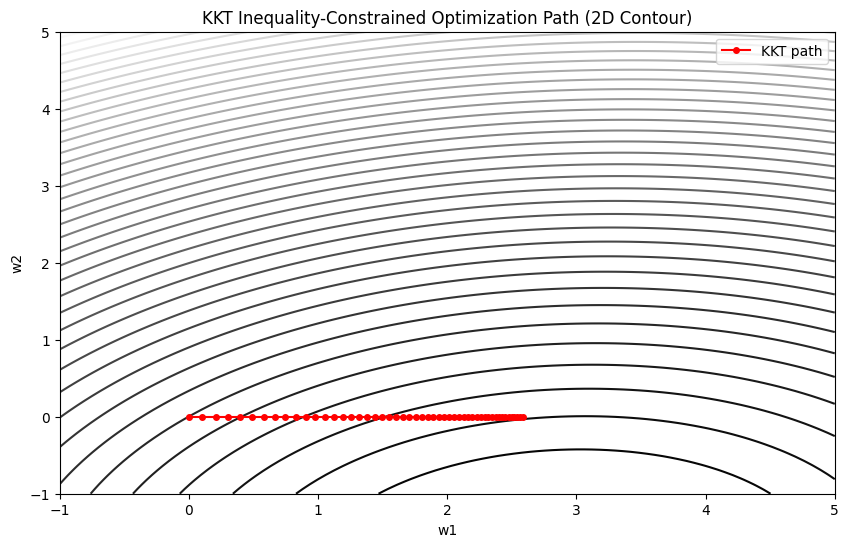

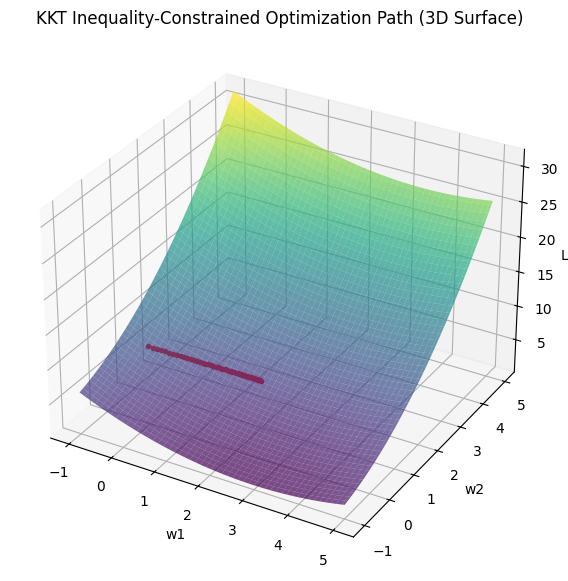

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Load dataset ---
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1", "x2", "x3"]].values
y = data["y"].values.reshape(-1, 1)
N = X.shape[0]

# Augment with bias
X_tilde = np.hstack([np.ones((N,1)), X])

# --- KKT projected gradient method ---
alpha = 0.05  # step size
max_it = 50
epsilon = 1e-6

# Initialize weights and multipliers
W = np.zeros((4,1))  # [bias, w1, w2, w3]
lambda_ = np.zeros((3,1))  # multipliers for inequality constraints
trajectory = [W.copy()]

for k in range(max_it):
    # Gradient of MSE loss
    y_hat = X_tilde @ W
    grad = (1/N) * X_tilde.T @ (y_hat - y)

    # Projected gradient update for inequality constraints
    W[1:] = W[1:] - alpha * grad[1:]

    # Enforce w_j >= 0 (primal feasibility)
    W[1:] = np.maximum(W[1:], 0)

    # Update Lagrange multipliers (dual feasibility + complementary slackness)
    lambda_ = np.maximum(lambda_ + alpha * (-W[1:]), 0)

    trajectory.append(W.copy())

    if np.linalg.norm(grad) < epsilon:
        break

trajectory = np.array(trajectory).squeeze()

# --- 2D Contour plot (w1 vs w2), fix w3 and bias ---
w3_fixed = 0
bias_fixed = 0

w1 = np.linspace(-1, 5, 100)
w2 = np.linspace(-1, 5, 100)
W1, W2 = np.meshgrid(w1, w2)
loss_grid = np.zeros_like(W1)

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([bias_fixed, W1[i,j], W2[i,j], w3_fixed]).reshape(-1,1)
        y_hat_grid = X_tilde @ w
        loss_grid[i,j] = np.mean(0.5 * (y_hat_grid - y)**2)

plt.figure(figsize=(10,6))
plt.contour(W1, W2, loss_grid, levels=50, cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2], 'ro-', markersize=4, label='KKT path')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('KKT Inequality-Constrained Optimization Path (2D Contour)')
plt.legend()
plt.show()

# --- 3D Surface plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, loss_grid, cmap='viridis', alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2], [np.mean(loss_grid)]*len(trajectory), 'r.-', label='KKT path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title('KKT Inequality-Constrained Optimization Path (3D Surface)')
plt.show()


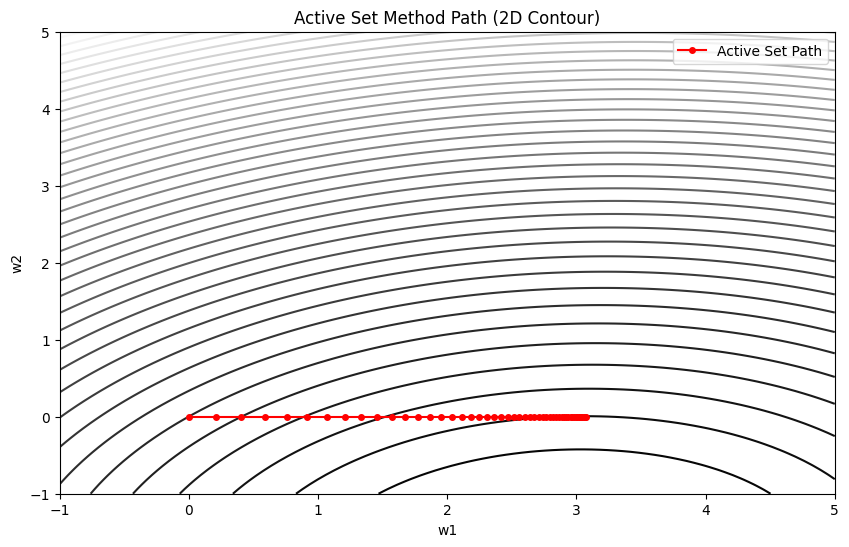

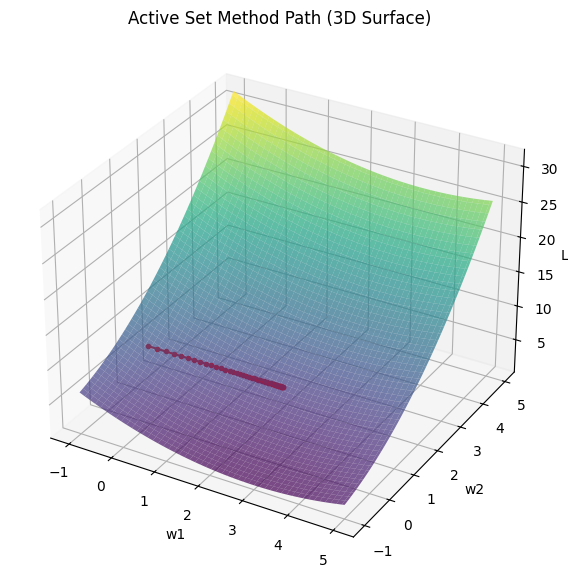

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Load dataset ---
data = pd.read_csv("optimization_dataset.csv")
X = data[["x1","x2","x3"]].values
y = data["y"].values.reshape(-1,1)
N = X.shape[0]

# Augment X with bias
X_tilde = np.hstack([np.ones((N,1)), X])
d_aug = X_tilde.shape[1]

# --- Active Set Method ---
max_it = 50
alpha = 0.1
epsilon = 1e-6

# Initialize weights
W = np.zeros((d_aug,1))
trajectory = [W.copy()]

for k in range(max_it):
    # Gradient of loss
    grad = (1/N) * X_tilde.T @ (X_tilde @ W - y)

    # Identify active set (w_j <= 0 and grad pushing outside feasible region)
    active_set = (W[1:] <= 0) & (grad[1:] > 0)

    # Free set indices
    free_set = ~active_set.squeeze()

    # Projected gradient: only update free set
    W_new = W.copy()
    W_new[1:][free_set] = W[1:][free_set] - alpha * grad[1:][free_set]

    # Enforce feasibility
    W_new[1:] = np.maximum(W_new[1:], 0)

    # Update
    W = W_new
    trajectory.append(W.copy())

    if np.linalg.norm(grad[1:][free_set]) < epsilon:
        break

trajectory = np.array(trajectory).squeeze()

# --- 2D Contour plot (w1 vs w2), fix w3 and bias ---
w_fixed = 0
bias_fixed = 0

w1 = np.linspace(-1,5,100)
w2 = np.linspace(-1,5,100)
W1, W2 = np.meshgrid(w1,w2)
loss_grid = np.zeros_like(W1)

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w = np.array([bias_fixed, W1[i,j], W2[i,j], w_fixed]).reshape(-1,1)
        y_hat_grid = X_tilde @ w
        loss_grid[i,j] = np.mean(0.5*(y_hat_grid - y)**2)

plt.figure(figsize=(10,6))
plt.contour(W1,W2,loss_grid,levels=50,cmap='gray')
plt.plot(trajectory[:,1], trajectory[:,2],'ro-',markersize=4,label='Active Set Path')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Active Set Method Path (2D Contour)')
plt.legend()
plt.show()

# --- 3D Surface plot ---
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(W1,W2,loss_grid,cmap='viridis',alpha=0.7)
ax.plot(trajectory[:,1], trajectory[:,2],[np.mean(loss_grid)]*len(trajectory),'r.-',label='Active Set Path')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('Loss')
ax.set_title('Active Set Method Path (3D Surface)')
plt.show()
